In [1]:
import numpy as np
import scipy
import seaborn as sns
import matplotlib.cm as cm
import matplotlib.colors as colors
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['svg.fonttype'] = 'none'

import bbi
import pybedtools as pbt
import pickle
import cooler
from copy import deepcopy
import itertools 

import sys
sys.path.append("./code")

from tad_functions import *
from treg_functions import *
from hic_zscore_functions import *
from plotting_functions import *
from aux_functions import *
from init_tss_annotations import *
gpath = './annotations/chromsizes'
import statsmodels.stats
import statsmodels.stats.multitest


In [2]:
%load_ext autoreload
%autoreload
import scanpy as sc

sc.settings.set_figure_params(dpi=80, color_map='coolwarm', frameon=True)
plt.rcParams.update({'font.size': 12})
plt.rcParams.update({"axes.grid.axis" : 'both'})
plt.rcParams.update({"axes.grid" : True})

plt.rcParams.update({
    'axes.labelsize': 14,       # x and y labels' font size
    'xtick.labelsize': 8,      # x tick labels' font size
    'ytick.labelsize': 8,      # y tick labels' font size
    'axes.titlesize': 14,        # Axes title font size
    'patch.linewidth' : .35,
    'lines.linewidth' : .5,
    'legend.fontsize': 6,      # Legend font size
})
plt.rcParams['pdf.fonttype'] = 42

plt.rcParams.update({
    'axes.labelsize': 8,       # x and y labels' font size
    'xtick.labelsize': 6,      # x tick labels' font size
    'ytick.labelsize': 6,      # y tick labels' font size
    'axes.titlesize': 10,        # Axes title font size
    'patch.linewidth' : .35,
    'lines.linewidth' : .5,
    'xtick.major.pad' : 2,
    'ytick.major.pad' : 2,

})
plt.rcParams['axes.linewidth'] = .25
plt.rcParams['xtick.major.width'] = .25
plt.rcParams['ytick.major.width'] = .25
plt.rcParams['ytick.major.size'] = 2
plt.rcParams['xtick.major.size'] = 2
plt.rcParams['grid.linewidth'] = .25

plt.rcParams['axes.facecolor'] = 'none' # Or any suitable colour...
plt.rcParams['figure.facecolor'] = 'none'
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['savefig.facecolor'] = 'none'

plt.rcParams['axes.facecolor'] = 'none' # Or any suitable colour...
plt.rcParams['figure.facecolor'] = 'none'
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['savefig.facecolor'] = 'none'

In [3]:
from config import row_colors, columns_to_names, row_colors_dict

2


In [4]:
import make_figure4
from make_figure4 import *
import pickle
from config import load_pileup_variables

(goodinds, merged_clustdict, merged_inds_to_subset, 
    cooldict_50kb, ind_to_gene, all_ind_to_region, my_treg_comp) = load_pileup_variables()

In [5]:
from initialize import *
import cooler 

treg_250kb = cooler.Cooler('./Treg_all.mcool::/resolutions/250000')
treg_50kb = cooler.Cooler('./Treg_all.mcool::/resolutions/50000')



# (_, _, region_to_inds_50kb, all_region_to_ind_50kb, 
#     inds_to_region_50kb, all_ind_to_region_50kb,
#     chrom_to_start_50kb, chrom_to_end_50kb) = initialize_helper_vars(treg_50kb)

In [9]:
pref = '/Genomics/argo/users/gdolsten/pritlab/mega_tcell_dataset/'
(chromsizes, parsed_chroms, region_to_inds, 
    all_region_to_ind, inds_to_region, all_ind_to_region, 
    chrom_to_start, chrom_to_end) = initialize_helper_vars(treg_250kb)

cd4_cool_250 = cooler.Cooler(pref + '/zoomified_merged_cools/CD4_24hr_stimulated.Human.mcool::/resolutions/250000')

(chromsizes_hum, parsed_chroms_hum, region_to_inds_hum, 
    all_region_to_ind_hum, inds_to_region_hum, all_ind_to_region_hum, 
    chrom_to_start_hum, chrom_to_end_hum) = initialize_helper_vars(cd4_cool_250, parsed_chroms=cd4_cool_250.chromnames)

cd4_human = cooler.Cooler(pref + '/zoomified_merged_cools/CD4_24hr_stimulated.Human.mcool::/resolutions/50000')
cd4_cool_dict = {
    'CD4' : cd4_human,
}


In [10]:
gene_to_ind = pickle.load(open('gene_to_ind.p', 'rb'))

Find Human metadomain bins

In [11]:
from map_to_humans import *

mouse_metadomains = pbt.BedTool('./for_susie/interchromosomal_interactions.bed')
human_50kb_metadomains, liftover_df = run_full_mouse_conversion(mouse_metadomains, path='./hg38_metadomain_liftover/human_regions.bed')

In [12]:
df = pd.DataFrame(human_50kb_metadomains)
df = df[((df[7].astype(int) - 88600000).abs() < 550_000) | ((df[10].astype(int) - 88600000).abs() < 550_000)]
df['ind1'] = df[7].astype(int)//250_000
df['ind2'] = df[10].astype(int)//250_000

In [13]:
mouse_matched_inter_50kb_metadomains = []
human_inter_50kb_metadomains = []
for i in human_50kb_metadomains:
    if i[0] != i[3]:
        human_inter_50kb_metadomains.append(i[:6])
        mouse_matched_inter_50kb_metadomains.append(i[6:])

In [14]:
mouse_matched_df = pd.DataFrame(mouse_matched_inter_50kb_metadomains)
human_matched_df = pd.DataFrame(human_inter_50kb_metadomains)

In [15]:
def convert_to_250kb_inds(tup):
    chrom, s, e = make_int(tup)
    chrom = chrom[3:]
    s_250 = (s//250_000)*250_000
    e_250 = (s_250 + 250_000)
    reg = (chrom, s_250, e_250)
    if reg not in all_region_to_ind:
        ind1_250 = -100
    else:
        ind1_250 = int(all_region_to_ind[reg])
    return ind1_250

inds1 = []
inds2 = []
for _, i in mouse_matched_df.iterrows():
    ind1_250 = convert_to_250kb_inds(i[:3].values)
    ind2_250 = convert_to_250kb_inds(i[3:6].values)
    inds1.append(ind1_250)
    inds2.append(ind2_250)

mouse_matched_df['ind1'] = inds1
mouse_matched_df['ind2'] = inds2

mouse_matched_df['ind1'] = mouse_matched_df['ind1'].astype(int)
mouse_matched_df['ind2'] = mouse_matched_df['ind2'].astype(int)

bad = (mouse_matched_df['ind1'] == -100) | (mouse_matched_df['ind1'] == -100)
human_matched_df.columns = ['chr1', 's1', 'e1', 'chr2', 's2', 'e2']
human_matched_df = human_matched_df[~bad]
mouse_matched_df = mouse_matched_df[~bad]

In [16]:
ind2clust = dict(zip(goodinds, merged_clustdict['all']))
cluster_inds = goodinds[np.isin(merged_clustdict['all'], merged_inds_to_subset)]

idx = mouse_matched_df['ind1'].isin(cluster_inds) & mouse_matched_df['ind2'].isin(cluster_inds)
mouse_matched_df = mouse_matched_df.loc[idx]
human_matched_df = human_matched_df.loc[idx]
human_matched_df['cluster1'] = mouse_matched_df['ind1'].apply(ind2clust.get)
human_matched_df['cluster2'] = mouse_matched_df['ind2'].apply(ind2clust.get)

In [17]:
human_matched_df['mouse_ind1'] = mouse_matched_df['ind1']
human_matched_df['mouse_ind2'] = mouse_matched_df['ind2']


human_matched_df['ind1'] = human_matched_df['s1']//250_000
human_matched_df['ind2'] = human_matched_df['s2']//250_000

human_matched_df['ind1_250'] = human_matched_df['s1']//250_000
human_matched_df['ind2_250'] = human_matched_df['s2']//250_000

In [18]:
human_matched_anchors = np.concatenate([
                human_matched_df.loc[:, human_matched_df.columns.str.contains("2")].drop("ind1_250", axis=1).values, 
                human_matched_df.loc[:, human_matched_df.columns.str.contains("1")].values], 
                                       axis=0)



In [19]:

human_matched_anchor_df = pd.DataFrame(human_matched_anchors,
                                      )
human_matched_anchor_df.columns = human_matched_df.columns[human_matched_df.columns.str.contains("1")].str.replace('1', '')
human_matched_anchor_df = human_matched_anchor_df.drop_duplicates(["chr", 'ind_250'])
human_matched_anchor_df = human_matched_anchor_df[(~human_matched_anchor_df['mouse_ind'].duplicated())]


human_matched_anchor_df = human_matched_anchor_df[human_matched_anchor_df['mouse_ind'].isin(goodinds)]
human_matched_anchor_df.loc[:, 'cluster'] = pd.Series(merged_clustdict['all'], goodinds
         ).loc[human_matched_anchor_df['mouse_ind'].values].values

human_matched_anchor_df.loc[:, 'chrom'] = human_matched_anchor_df['chr']
human_matched_anchor_df['chr_ind'] = human_matched_anchor_df['ind'].copy()

newind = []
for _, row in human_matched_anchor_df.iterrows():
    x, y = row['ind'], row['chr']
    newind.append(x + chrom_to_start_hum[y])

human_matched_anchor_df['ind'] = newind


### Make Figure 4C

In [20]:
%load_ext autoreload
%autoreload 2
    
from collections import defaultdict
from make_figure4 import *
from hub_pileup import *
import itertools

pref = '/Genomics/argo/users/gdolsten/pritlab/mega_tcell_dataset/'
cd4_cool = cooler.Cooler(pref + '/zoomified_merged_cools/CD4_24hr_stimulated.Human.mcool::/resolutions/25000')
human_cooldict = {
    'CD4' : cd4_cool
}

padding_size = 50

inter_all_mat_dict, inter_all_metadata = pileup_bins_with_hub(human_matched_anchor_df, human_cooldict, 
                                                              chrom_to_start_hum,
                                                              None, 
                                                              None, 
                                                              padding_size=padding_size, 
                                                              fetch_oe=True,
                                                              resolution_out = 25_000,
                                                             skip_metadomains=True)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Done with chr10
Done with chr11
Done with chr11
Done with chr12
Done with chr12
Done with chr12
Done with chr13
Done with chr13
Done with chr13
Done with chr13
Done with chr14
Done with chr14
Done with chr14
Done with chr14
Done with chr14
Done with chr15
Done with chr15
Done with chr15
Done with chr15
Done with chr15
Done with chr15
Done with chr16
Done with chr16
Done with chr16
Done with chr16
Done with chr16
Done with chr16
Done with chr16
Done with chr17
Done with chr17
Done with chr17
Done with chr17
Done with chr17
Done with chr17
Done with chr17
Done with chr17
Done with chr18
Done with chr18
Done with chr18
Done with chr18
Done with chr18
Done with chr18
Done with chr18
Done with chr18
Done with chr18
Done with chr19
Done with chr19
Done with chr19
Done with chr19
Done with chr19
Done with chr19
Done with chr19
Done with chr19
Done with chr19
Done with chr19
Done with chr2
Done with chr2
Do

CD4


/Genomics/pritykinlab/gabe/jupys/tregs/./code/hub_pileup.py:401: UserWarning: FixedFormatter should only be used together with FixedLocator
  a.set_yticklabels([-cutoff, "Anchor1", cutoff])
/Genomics/pritykinlab/gabe/jupys/tregs/./code/hub_pileup.py:439: UserWarning: FixedFormatter should only be used together with FixedLocator
  a.set_yticklabels([-cutoff, "Anchor1", cutoff])


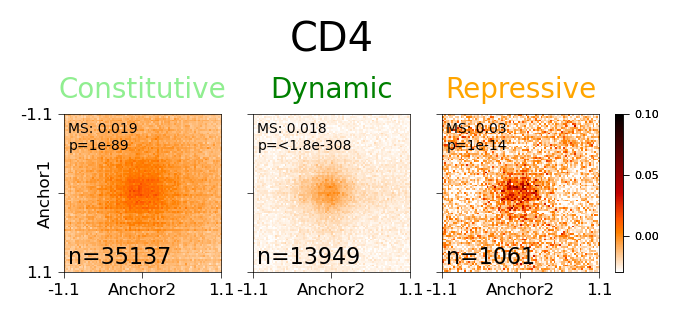

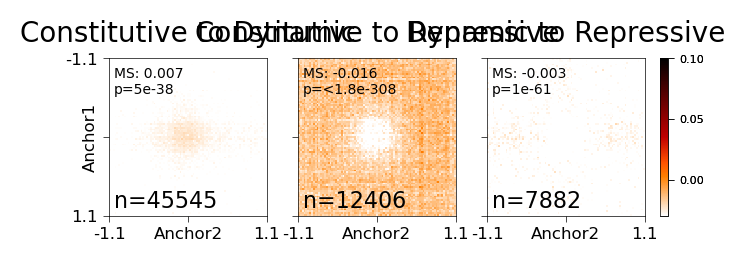

In [21]:
!mkdir -p plots/inter_saka_pileup

newline = '\n'
all_results_dicts = {}
for key in inter_all_mat_dict:
    print(key)
    (fig_within_cluster, fig_between_cluster), results = plot_cluster_pileups_from_result(key, inter_all_mat_dict, inter_all_metadata,
                                     [0, 4, 18],
                                     res = 25_000,
                                     vmax = .10,
                                     vmin = -.03,
                                     columns_to_names = columns_to_names,
                                     row_colors_dict = row_colors_dict,
                                     s1 = 10,
                                     center = 5, center_method='None'
                                )
    fig_within_cluster.suptitle(f"{key}", y=4, x=1.7, ha='center')
    fig_within_cluster.savefig(f'./plots/paper/fig4/{key}_within_cluster.pdf', bbox_inches='tight')
    fig_between_cluster.savefig(f'./plots/paper/fig4/{key}_between_cluster.pdf', bbox_inches='tight')
    all_results_dicts[key] = results

#### Make Figure 2J

In [22]:
inter_and_intra_metadomains_treg = (  np.load('./intermediate_files/all_intra_treg_metadomains.npy') 
                                    + np.load('./intermediate_files/all_inter_treg_metadomains.npy') 
                                   ) > 0
inter_and_intra_metadomains_tcon = (  np.load('./intermediate_files/all_intra_tcon_metadomains.npy') 
                                    + np.load('./intermediate_files/all_inter_tcon_metadomains.npy') 
                                   ) > 0

In [23]:
from map_to_humans import *

liftover_df2 = process_liftover_output('./hg38_metadomain_liftover/human_regions.bed')
mouse_metadomains = pbt.BedTool('./for_susie/intrachromosomal_interactions_treg.bed')

In [24]:
rows = [] 
for _, row in liftover_df2.iterrows():
    rows.append(list(row) + list(remove_chr_anc(grange_to_tuple(row['mouse_start']))))

data = pd.DataFrame(rows, columns = list(liftover_df2.columns) + list(['mouse_chr', 'mouse_s', 'mouse_e']))
data['mouse_ind'] = data['mouse_s'].astype(int)//250_000 + data['mouse_chr'].apply(chrom_to_start.get)

data['ind'] = data['start']//250_000
data.loc[:, 'ind'] += data['chrom'].apply(chrom_to_start_hum.get)

data = data.drop_duplicates('mouse_ind').sort_values(["chrom", "start"])
data = data[(data['chrom'] != 'chrX') & (data['chrom'] != 'chrY')]
data = data.drop_duplicates('ind')
data = data.iloc[::2]


In [25]:
df1 = []
df2 = []
for chrom in data['chrom'].unique():
    comboL, comboR = list(zip(*itertools.combinations(data.index[data['chrom']==chrom], 2)))
    df1.append(data.loc[list(comboL)])
    df2.append(data.loc[list(comboR)])

In [26]:
df1 = pd.concat(df1, axis=0)
df2 = pd.concat(df2, axis=0)

In [27]:
df1['ind'] = df1['ind'].astype(int)
df2['ind'] = df2['ind'].astype(int)

In [28]:
has_metadomain = inter_and_intra_metadomains_treg[df1['mouse_ind'], df2['mouse_ind']].astype(object)
has_metadomain[has_metadomain>0] = 'With metadomain'
has_metadomain[has_metadomain==0] = 'Without metadomain'

df1.loc[:, 'cluster'] = has_metadomain
df2.loc[:, 'cluster'] = has_metadomain

In [29]:
%autoreload 2
    
from collections import defaultdict
from make_figure4 import *
from hub_pileup import *
import itertools

pref = '/Genomics/argo/users/gdolsten/pritlab/mega_tcell_dataset/'
cd4_cool = cooler.Cooler(pref + '/zoomified_merged_cools/CD4_24hr_stimulated.Human.mcool::/resolutions/50000')
human_cooldict = {
    'CD4' : cd4_cool
}

metadomain_pileup_cooldict = cd4_cool_dict
padding_size = 30

intra_all_mat_dict, intra_all_metadata = pileup_direct_bin_pairs(df1.reset_index(), df2.reset_index(), human_cooldict, 
                                                              chrom_to_start_hum,
                                                              None, 
                                                              None, 
                                                              padding_size=padding_size, 
                                                              fetch_oe=True,
                                                              resolution_out = 50_000,
                                                              inter=False,
                                                              intra=True,
                                                              skip_metadomains=True, skip = 1,
                                                              log=False,
                                                    )

/Genomics/pritykinlab/gabe/jupys/tregs/./code/hic_zscore_functions.py:148: RuntimeWarning: Mean of empty slice
  m = np.nanmean(np.diag(balanced_mat, k=off_diag_k))


Done with chr3


/Genomics/pritykinlab/gabe/jupys/tregs/./code/hic_zscore_functions.py:148: RuntimeWarning: Mean of empty slice
  m = np.nanmean(np.diag(balanced_mat, k=off_diag_k))


Done with chr9


/Genomics/pritykinlab/gabe/jupys/tregs/./code/hic_zscore_functions.py:148: RuntimeWarning: Mean of empty slice
  m = np.nanmean(np.diag(balanced_mat, k=off_diag_k))


Done with chr20


/Genomics/pritykinlab/gabe/jupys/tregs/./code/hic_zscore_functions.py:148: RuntimeWarning: Mean of empty slice
  m = np.nanmean(np.diag(balanced_mat, k=off_diag_k))


Done with chr11


/Genomics/pritykinlab/gabe/jupys/tregs/./code/hic_zscore_functions.py:148: RuntimeWarning: Mean of empty slice
  m = np.nanmean(np.diag(balanced_mat, k=off_diag_k))


Done with chr22


/Genomics/pritykinlab/gabe/jupys/tregs/./code/hic_zscore_functions.py:148: RuntimeWarning: Mean of empty slice
  m = np.nanmean(np.diag(balanced_mat, k=off_diag_k))


Done with chr14


/Genomics/pritykinlab/gabe/jupys/tregs/./code/hic_zscore_functions.py:148: RuntimeWarning: Mean of empty slice
  m = np.nanmean(np.diag(balanced_mat, k=off_diag_k))


Done with chr19


/Genomics/pritykinlab/gabe/jupys/tregs/./code/hic_zscore_functions.py:148: RuntimeWarning: Mean of empty slice
  m = np.nanmean(np.diag(balanced_mat, k=off_diag_k))


Done with chr1


/Genomics/pritykinlab/gabe/jupys/tregs/./code/hic_zscore_functions.py:148: RuntimeWarning: Mean of empty slice
  m = np.nanmean(np.diag(balanced_mat, k=off_diag_k))


Done with chr16


/Genomics/pritykinlab/gabe/jupys/tregs/./code/hic_zscore_functions.py:148: RuntimeWarning: Mean of empty slice
  m = np.nanmean(np.diag(balanced_mat, k=off_diag_k))


Done with chr18


/Genomics/pritykinlab/gabe/jupys/tregs/./code/hic_zscore_functions.py:148: RuntimeWarning: Mean of empty slice
  m = np.nanmean(np.diag(balanced_mat, k=off_diag_k))


Done with chr4


/Genomics/pritykinlab/gabe/jupys/tregs/./code/hic_zscore_functions.py:148: RuntimeWarning: Mean of empty slice
  m = np.nanmean(np.diag(balanced_mat, k=off_diag_k))


Done with chr13


/Genomics/pritykinlab/gabe/jupys/tregs/./code/hic_zscore_functions.py:148: RuntimeWarning: Mean of empty slice
  m = np.nanmean(np.diag(balanced_mat, k=off_diag_k))


Done with chr12


/Genomics/pritykinlab/gabe/jupys/tregs/./code/hic_zscore_functions.py:148: RuntimeWarning: Mean of empty slice
  m = np.nanmean(np.diag(balanced_mat, k=off_diag_k))


Done with chr15


/Genomics/pritykinlab/gabe/jupys/tregs/./code/hic_zscore_functions.py:148: RuntimeWarning: Mean of empty slice
  m = np.nanmean(np.diag(balanced_mat, k=off_diag_k))


Done with chr6


/Genomics/pritykinlab/gabe/jupys/tregs/./code/hic_zscore_functions.py:148: RuntimeWarning: Mean of empty slice
  m = np.nanmean(np.diag(balanced_mat, k=off_diag_k))


Done with chr21


/Genomics/pritykinlab/gabe/jupys/tregs/./code/hic_zscore_functions.py:148: RuntimeWarning: Mean of empty slice
  m = np.nanmean(np.diag(balanced_mat, k=off_diag_k))


Done with chr10


/Genomics/pritykinlab/gabe/jupys/tregs/./code/hic_zscore_functions.py:148: RuntimeWarning: Mean of empty slice
  m = np.nanmean(np.diag(balanced_mat, k=off_diag_k))


Done with chr8


/Genomics/pritykinlab/gabe/jupys/tregs/./code/hic_zscore_functions.py:148: RuntimeWarning: Mean of empty slice
  m = np.nanmean(np.diag(balanced_mat, k=off_diag_k))


Done with chr2


/Genomics/pritykinlab/gabe/jupys/tregs/./code/hic_zscore_functions.py:148: RuntimeWarning: Mean of empty slice
  m = np.nanmean(np.diag(balanced_mat, k=off_diag_k))


Done with chr17


/Genomics/pritykinlab/gabe/jupys/tregs/./code/hic_zscore_functions.py:148: RuntimeWarning: Mean of empty slice
  m = np.nanmean(np.diag(balanced_mat, k=off_diag_k))


Done with chr5


/Genomics/pritykinlab/gabe/jupys/tregs/./code/hic_zscore_functions.py:148: RuntimeWarning: Mean of empty slice
  m = np.nanmean(np.diag(balanced_mat, k=off_diag_k))


Done with chr7


In [30]:
intra_all_metadata.loc[(intra_all_metadata['ind1'] - intra_all_metadata['ind2']).abs() <= 16, 'cluster1'] = '<2Mb'
intra_all_metadata.loc[(intra_all_metadata['ind1'] - intra_all_metadata['ind2']).abs() <= 16, 'cluster2'] = '<2Mb'

CD4


/Genomics/pritykinlab/gabe/jupys/tregs/./code/compute_differential_hic_hub.py:75: RuntimeWarning: Mean of empty slice
  v_middle = np.nanmean(ms_treg[:, inside_filt], axis=1)
/Genomics/pritykinlab/gabe/jupys/tregs/./code/compute_differential_hic_hub.py:76: RuntimeWarning: Mean of empty slice
  v_outside = np.nanmean(ms_treg[:, outside_filt], axis=1)
/Genomics/pritykinlab/gabe/jupys/tregs/./code/hub_pileup.py:401: UserWarning: FixedFormatter should only be used together with FixedLocator
  a.set_yticklabels([-cutoff, "Anchor1", cutoff])
/Genomics/pritykinlab/gabe/jupys/tregs/./code/hub_pileup.py:581: RuntimeWarning: Mean of empty slice
  mat = np.nanmean(mats, axis=0)
/Genomics/argo/users/gdolsten/.conda/envs/mamba/envs/new_3dgenome/lib/python3.10/site-packages/scipy/stats/_stats_py.py:9205: RuntimeWarning: invalid value encountered in scalar divide
  z = (s - expected) / np.sqrt(n1*n2*(n1+n2+1)/12.0)
/Genomics/pritykinlab/gabe/jupys/tregs/./code/compute_differential_hic_hub.py:138: Run

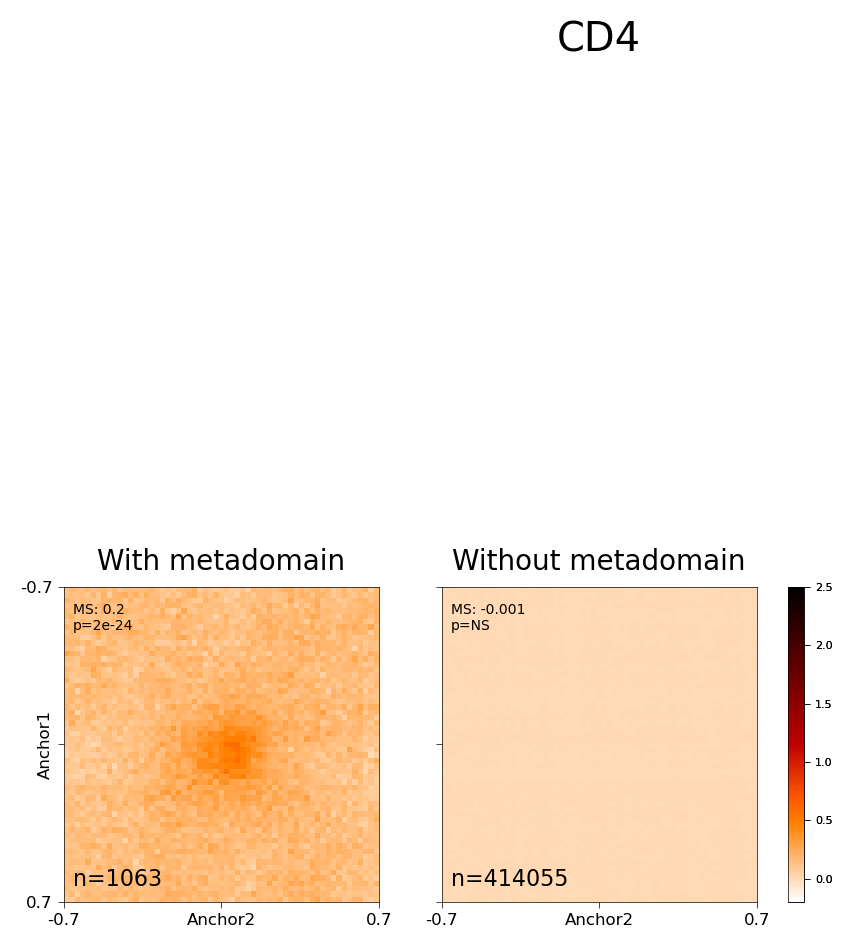

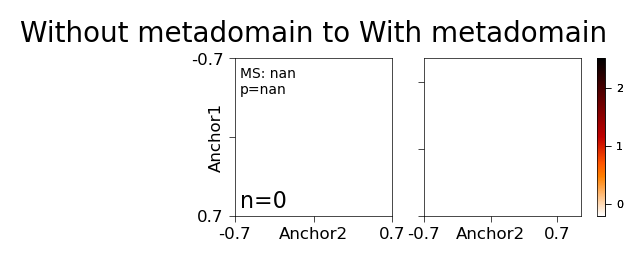

In [31]:
!mkdir -p plots/intra_human_pileup

newline = '\n'
all_results_dicts = {}
for key in intra_all_mat_dict:
    print(key)
    (fig_within_cluster, fig_between_cluster), results = plot_cluster_pileups_from_result(key, intra_all_mat_dict, intra_all_metadata,
                                     [
                                      'Without metadomain',
                                      'With metadomain'
                                     ],
                                     res = 25_000,
                                     vmax = 2.5,
                                     vmin = -.2,
                                     columns_to_names = columns_to_names,
                                     row_colors_dict = row_colors_dict, s2=None,
                                     # s1 = 10,
                                     center = 5,                                     
                                     center_method='None', log=True,
                                     fgsz=(40*mm, 40*mm),
                                     delta_co = .005,
                                    )
    fig_within_cluster.suptitle(f"{key}", y=4, x=1.7, ha='center')
    fig_within_cluster.savefig(f'./plots/paper/fig2/with_metadomain.pdf', bbox_inches='tight')
    all_results_dicts[key] = results

/Genomics/argo/users/gdolsten/.conda/envs/mamba/envs/new_3dgenome/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Genomics/argo/users/gdolsten/.conda/envs/mamba/envs/new_3dgenome/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Genomics/argo/users/gdolsten/.conda/envs/mamba/envs/new_3dgenome/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


Comparison of With metadomain and Without metadomain
p-value: 6.79115691671819e-129
stat: 24.15391938792723


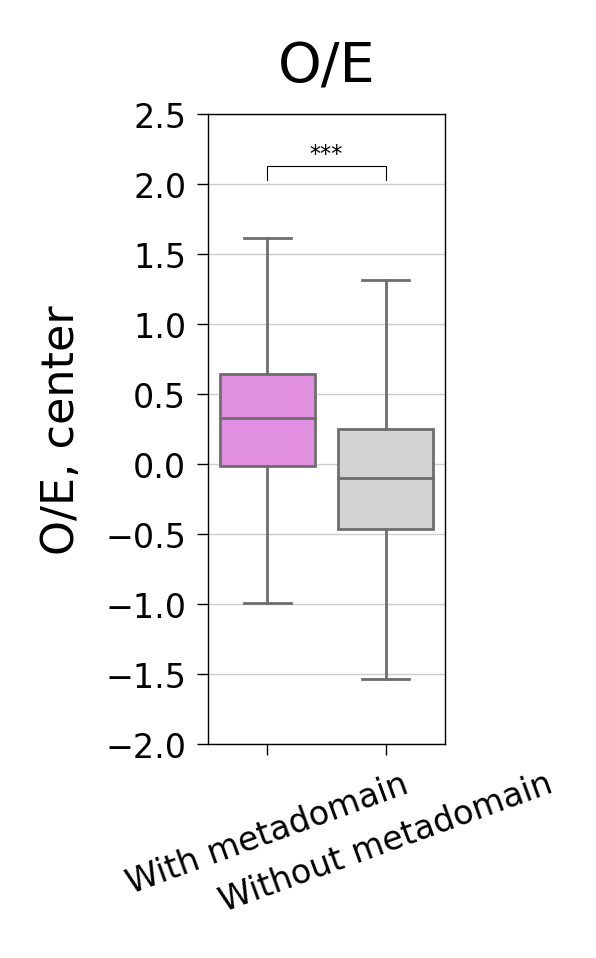

In [32]:
%autoreload 2
!mkdir -p plots/intra_treg
from plot_pvals import add_stat_annotation_boxplot_no_hue
from itertools import combinations

all_datas = []
for u in ['With metadomain', 'Without metadomain'
         ]:
    idx = (intra_all_metadata['cluster1']==u) & (intra_all_metadata['cluster2']==u)
    data = pd.DataFrame()
    for key in intra_all_mat_dict:
        difference = np.log2(all_results_dicts[key][u]['v_middle'])
        data[key] = difference
    data['cluster'] = u
    all_datas.append(data)

data = pd.concat(all_datas, axis=0)
data = data.melt('cluster')

order = ['Treg']
hue_order = ['With metadomain', 'Without metadomain'
            ]
pairs = [((x, h1), (x, h2)) for x in order for h1, h2 in combinations(hue_order, 2)]

fig, axs = init_subplots_exact(1, 1, fgsz=(15*mm, 40*mm), dpi = 200)
sns.boxplot(data=data, x='cluster', y='value', fliersize=0,
           hue_order = hue_order,
           palette=['violet', 'lightgray', ]
           )
plt.ylim([-2, 2.5])
plt.gca().set_axisbelow(True)
# add_stat_annotation(plt.gca(), data, 'variable', 'value', 'cluster', order, hue_order, pairs)
add_stat_annotation_boxplot_no_hue(plt.gca(), data, 'cluster', 'value', hue_order, [hue_order], ymax=1.75, delta = .15, h = 0.1,
                                  log=True)

plt.xlabel("")
plt.ylabel("O/E, center")
plt.title("O/E")
plt.xticks(rotation=20)
fig.savefig('./plots/paper/fig2/intra_human_pileup/quantification.pdf', bbox_inches = 'tight')